# Convolutional Neural Network for Disparity Image Generation from Stereo Pairs

In [22]:
import keras
import tensorflow as tf
import torch

# allow gpu growth. This prevents the gpu from running out of memory to quickly
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
# from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Concatenate, UpSampling2D
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.utils import to_categorical
import os


## Load images from directory. 
#### We left images, right images and disparity images for supervised training. The disparity images are only needed for training. And to compare our testing resuts with. But we can do away with these when we deploy the network.

I've got my images organised as follows.
- Right images in direcotry  _./frames_out/stereo_out/right_
- Left images in directory  _./frames_out/stereo_out/left_
- Ground truth disparity images in directory  _./frames_out/tof_out_


In [23]:
import os
import cv2
import numpy as np

def load_images_from_directories(input_directory1, input_directory2, output_directory):
    # Get list of image files in the input directory, sorted alphabetically
    input_image_files1 = sorted([file for file in os.listdir(input_directory1) if file.endswith(('.jpg', '.jpeg', '.png'))])
    input_image_files2 = sorted([file for file in os.listdir(input_directory2) if file.endswith(('.jpg', '.jpeg', '.png'))])
    
    # Get list of image files in the output directory, sorted alphabetically
    output_image_files = sorted([file for file in os.listdir(output_directory) if file.endswith(('.jpg', '.jpeg', '.png'))])

    # Ensure the number of input images matches the number of output images
    assert len(input_image_files1) == len(output_image_files), "Number of input images does not match number of output images"
    assert len(input_image_files2) == len(output_image_files), "Number of input images does not match number of output images"

    # Use list comprehension and zip to read both input and output images into two separate lists
    input_images1 = [cv2.imread(os.path.join(input_directory1, filename)) for filename in input_image_files1]
    input_images2 = [cv2.imread(os.path.join(input_directory2, filename)) for filename in input_image_files2]
    output_images = [cv2.medianBlur(cv2.imread(os.path.join(output_directory, filename), cv2.IMREAD_GRAYSCALE),5) for filename in output_image_files]

    # Convert the lists of images to numpy arrays
    input_images_array1 = np.array(input_images1)
    input_images_array2 = np.array(input_images2)
    output_images_array = np.array(output_images)

    return input_images_array1, input_images_array2, output_images_array


In [24]:
left_directory = "./frames_out/stereo_out/left"
right_directory = "./frames_out/stereo_out/right"
output_images = "./frames_out/tof_out"

In [25]:
input_images_array1, input_images_array2, output_images_array = load_images_from_directories(left_directory,right_directory,output_images)

print(input_images_array1.shape, input_images_array2.shape, output_images_array.shape)

(481, 180, 240, 3) (481, 180, 240, 3) (481, 180, 240)


##### Shuffle the images so that they are not in order. 
If you want the same result everytime you run, you can set a random seed.

In [26]:
import numpy as np

def shuffle_arrays(*arrays):
    # Get the number of samples
    num_samples = arrays[0].shape[0]

    # Generate a random permutation of indices
    permutation = np.random.permutation(num_samples)

    # Shuffle all arrays using the same permutation
    shuffled_arrays = [array[permutation] for array in arrays]

    return shuffled_arrays


input_images_array1, input_images_array2, output_images_array = shuffle_arrays(input_images_array1, input_images_array2, output_images_array )

#### Take the first 20 images of the shuffled set for testing. These will not be used in training. And only for testing.

In [27]:
input_images_tst1, input_images_tst2, output_images_sts = input_images_array1[0:20], input_images_array2[0:20], output_images_array[0:20]
input_images_array1, input_images_array2, output_images_array = input_images_array1[20:], input_images_array2[20:], output_images_array[20:]
print(input_images_array1.shape, input_images_array2.shape)



(461, 180, 240, 3) (461, 180, 240, 3)


#### Create network

This is a CNN with two inputs, one for the left image and one for the right image.
We apply each image to a convolution filter and then do the concatenation. 
You can play around with this: 
- Add more layers, 
- change the pooling, 
- update number of nodes.

Only make sure the output dimension is the same as your training image. In my case the training images (which I got from the time of flight camera) are 180x240.
A summary of the model is printed below.

In [28]:
# Define the two input images
input_img1 = Input(shape=(180, 240, 3))  # Shape for the first image
input_img2 = Input(shape=(180, 240, 3))  # Shape for the second image
l_params = [128, 128, 128,256, 128, 128] #size of convolutional networks
# Convolutional layers for the first image
x1 = Conv2D(l_params[0], (3, 3), activation='relu', padding='same')(input_img1)
x1 = MaxPooling2D((2, 2), padding='same')(x1)

# Convolutional layers for the second image
x2 = Conv2D(l_params[1], (3, 3), activation='relu', padding='same')(input_img2)
x2 = MaxPooling2D((2, 2), padding='same')(x2)

# Concatenate the outputs of the two convolutional layers
combined = Concatenate()([x1, x2])

# combined = Conv2D(128, (3,3), activation='relu', padding='same')(combined)
# combined = MaxPooling2D((2, 2), padding='same')(combined)

# Continue with the rest of your model
x = Conv2D(l_params[2], (3, 3), activation='relu', padding='same')(combined) #stay at 128
x = Conv2D(l_params[3], (3, 3), activation='relu', padding='same')(x)
x = Conv2D(l_params[3], (3, 3), activation='relu', padding='same')(x)
x = Conv2D(l_params[3], (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(l_params[3], (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(l_params[3], (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(l_params[3], (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(l_params[3], (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(l_params[4], (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(l_params[5], (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
# original model had sigmoid. Trying relu, because original was on binary images.
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)# this model maps an input to its reconstruction
# decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)# this model maps an input to its reconstruction
# autoencoder = Model(input_img, decoded)
# autoencoder.summary()
model = Model(inputs=[input_img1, input_img2], outputs=decoded)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 180, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 180, 240,  │      3,584 │ input_layer_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 180, 240,  │      3,584 │ input_layer_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 90, 120,   │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 90, 120,   │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 90, 120,   │          0 │ max_pooling2d_3[… │
│ (Concatenate)       │ 256)              │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 90, 120,   │    295,040 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 90, 120,   │    295,168 │ conv2d_9[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 90, 120,   │    590,080 │ conv2d_10[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 45, 60,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 45, 60,    │    295,040 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 90, 120,   │          0 │ conv2d_12[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 90, 120,   │    147,584 │ up_sampling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 180, 240,  │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 180, 240,  │      1,153 │ up_sampling2d_3[… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,631,233 (6.22 MB)

 Trainable params: 1,631,233 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

##### Compile the model
##### Fit the model. Note if you are using too much memory, you can change the batch_size.

In [29]:

model.compile(optimizer = 'Adam', loss = "binary_crossentropy")#,  metrics =["accuracy"])
# model.compile(optimizer = 'Adam', loss = "mse")#,  metrics =["accuracy"])
# import os

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'



In [30]:

model.fit([input_images_array1.astype('float32')/255.0,input_images_array2.astype('float32')/255.0], output_images_array.astype('float32')/255.0, epochs=500, batch_size=32,verbose=1)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 704ms/step - loss: 0.1362
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0594
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0493
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0407
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0485
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0459
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0380
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0376
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0437
Epoch 10/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0386
Epoch 11/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0355
Epoch 12/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0340
Epoch 13/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0320
Epoch 14/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0355
Epoch 15/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s

In [31]:
### Save the model if you want to.
# l_params = [512, 256, 128, 256, 256, 512]
joined_string = '_'.join(map(str, l_params))
model.save('my_model_mse_v3_'+joined_string+'.keras')


In [44]:
from keras.models import load_model

model = load_model("my_model_binary_xentropy_128_128_128_256_128_128.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 180, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 180, 240,  │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 180, 240,  │      3,584 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 90, 120,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 90, 120,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 90, 120,   │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 256)              │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 90, 120,   │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 90, 120,   │    295,168 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 90, 120,   │    590,080 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 90, 120,   │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 45, 60,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 45, 60,    │    295,040 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 90, 120,   │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 90, 120,   │    147,584 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 180, 240,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 180, 240,  │      1,153 │ up_sampling2d_1[

 Total params: 6,663,941 (25.42 MB)

 Trainable params: 2,221,313 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,442,628 (16.95 MB)

In [38]:
encode_imgs = model.predict([input_images_tst1.astype('float32')/255.0,input_images_tst2.astype('float32')/255.0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [39]:
encode_imgs = (encode_imgs*255.0).astype('uint8')


In [40]:
encode_imgs.shape

(20, 180, 240, 1)

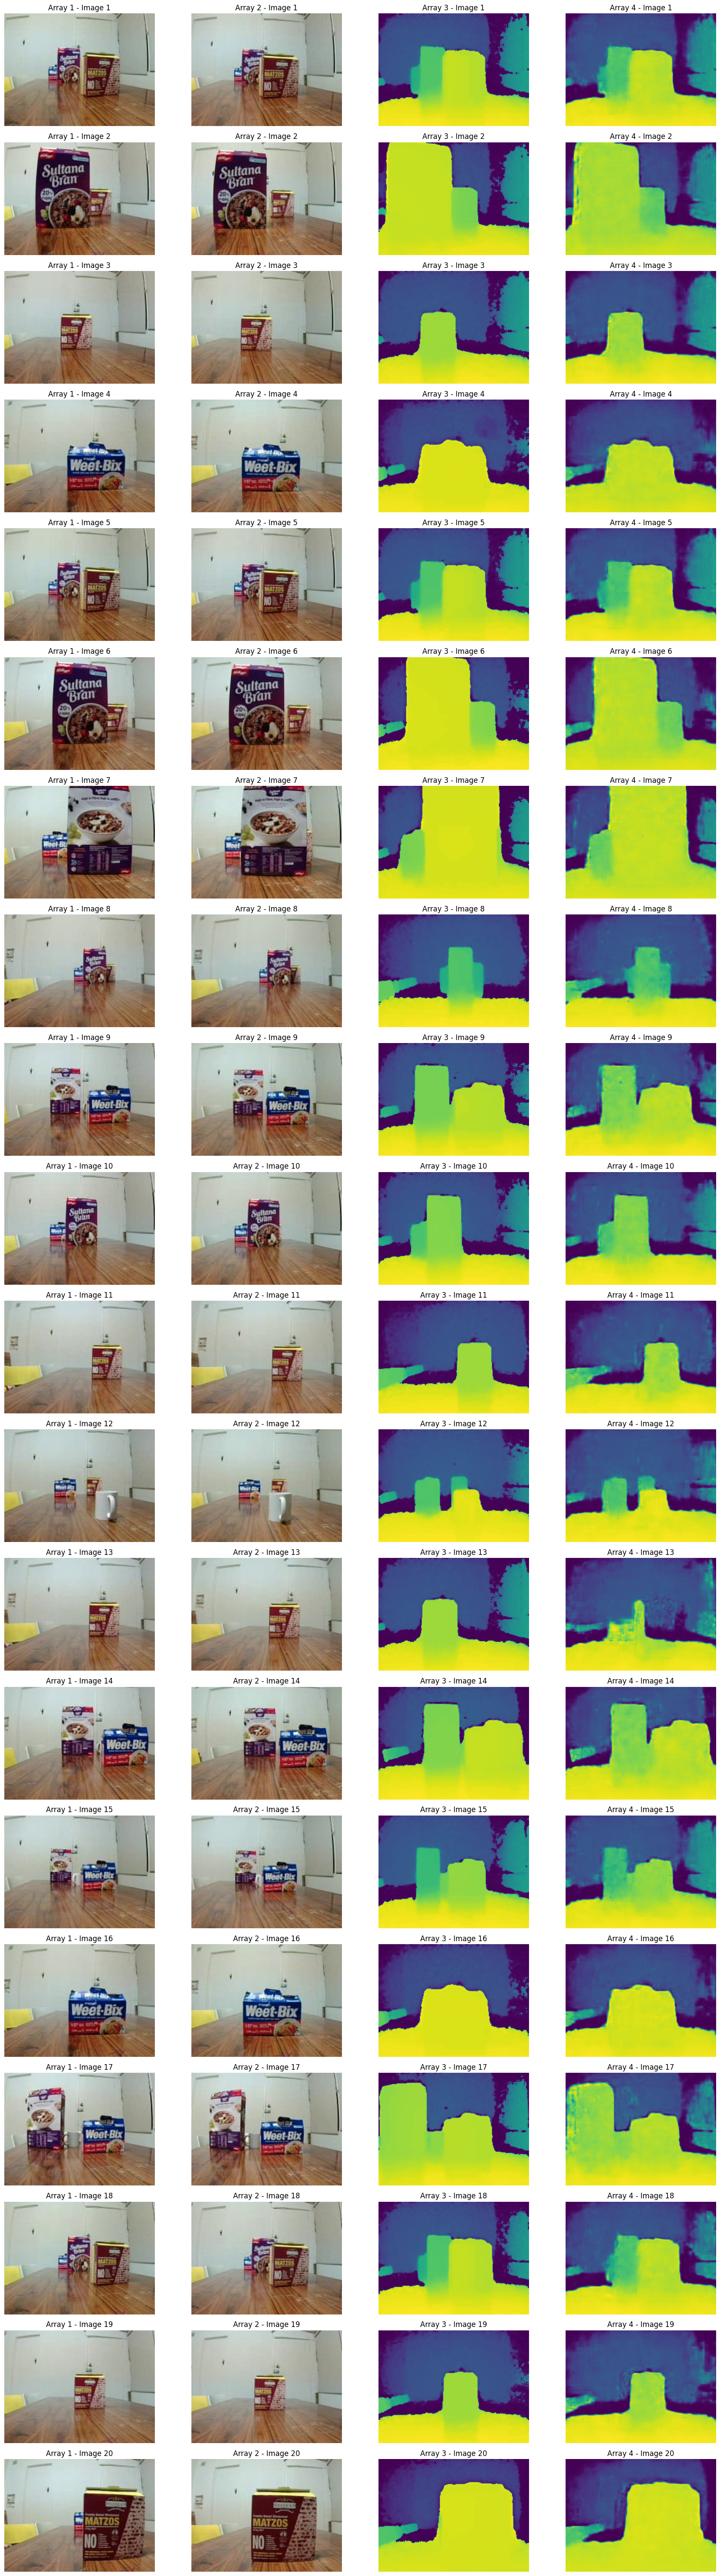

In [41]:
import matplotlib.pyplot as plt

# Assuming you have four arrays: array1, array2, array3, array4, each containing 10 images
# Each array is a list of images

# Assuming array1, array2, array3, array4 are your arrays

fig, axs = plt.subplots(20, 4, figsize=(18, 60))

for i, (arr1_img, arr2_img, arr3_img, arr4_img) in enumerate(zip(input_images_tst1, input_images_tst2, output_images_sts, encode_imgs)):
    # Plot images from array1
    axs[i, 0].imshow(arr1_img[...,::-1])
    axs[i, 0].set_title(f"Array 1 - Image {i+1}")
    axs[i, 0].axis('off')

    # Plot images from array2
    axs[i, 1].imshow(arr2_img[...,::-1])
    axs[i, 1].set_title(f"Array 2 - Image {i+1}")
    axs[i, 1].axis('off')

    # Plot images from array3
    axs[i, 2].imshow(arr3_img)
    axs[i, 2].set_title(f"Array 3 - Image {i+1}")
    axs[i, 2].axis('off')

    # Plot images from array4
    axs[i, 3].imshow(arr4_img)
    axs[i, 3].set_title(f"Array 4 - Image {i+1}")
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()


# display_image_pair(encode_imgs[2,:,:,0], encode_imgs[5,:,:,0])
#